In [ ]:
%load core.py

/home/lachlan/.pyenv/versions/venv_readoutxfm/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---------------------------
PATHS
---------------------------
base: /home/lachlan/CODEBASE/ReadoutXFM
data: /home/lachlan/CODEBASE/ReadoutXFM/data
output: /home/lachlan/CODEBASE/ReadoutXFM/out
---------------------------
file: /home/lachlan/CODEBASE/ReadoutXFM/data/geo2.GeoPIXE
---------------------------
---------------------------
PARSING HEADER
---------------------------
filesize: 195154338 (bytes)
header length: 1492 (bytes)
map dimensions: 256 x 126
pixels expected: 32256
---------------------------
saving spectrum-by-pixel to file 193333742 (99.1 %)
---------------------------
MAP COMPLETE
---------------------------
pixels expected (X*Y): 32256
pixels found: 32256
total time: 62.18 s
time per pixel: 0.001928 s
---------------------------
---------------------------
Memory usage:
---------------------------

                          data: 252.0 MiB
                        stream: 186.1 MiB
                         rvals: 252.1 KiB
                         bvals: 252.1 KiB
     

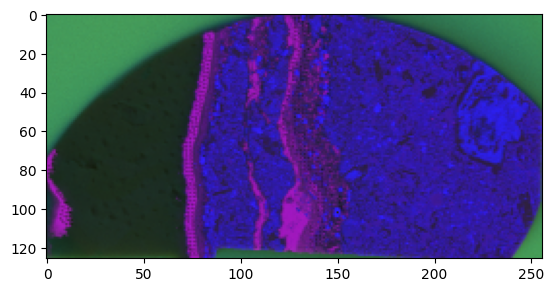

REDUCER 1 of 2: PCA across 32256 elements
REDUCER 2 of 2: UMAP across 32256 elements
KMEANS clustering 1 of 2, reducer PCA across 32256 elements
KMEANS clustering 2 of 2, reducer UMAP across 32256 elements
saving combined file for PCA with shape (4096,)
saving combined file for UMAP with shape (4096,)


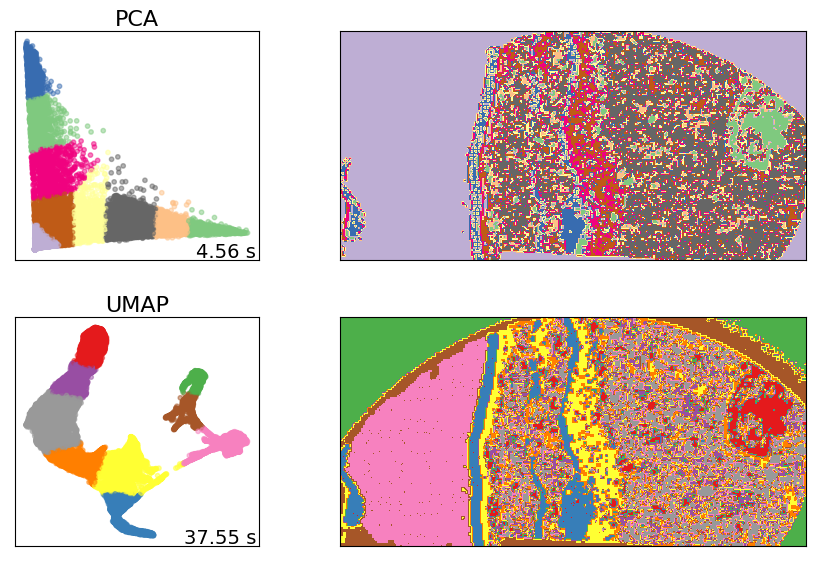

CLEAN EXIT


'\nruntime log:\n                            t/px\nreading only:               0.000140 s\n+clustering                 0.001296 s     \ncolourmap:                  0.007800 s\n\nimproving colourmap:    \n    for j:                  0.007625 s\n    vectorise channels:     0.004051 s\n    pre-init gaussians:     0.002641 s   \n    fully vectorised:       0.001886 s\nadd background fitting:\n    snip:               0.002734 s\n    complex snip:       0.002919 s\n'

In [1]:
# %load core.py
import os
import time
import gc
import time

import numpy as np

import config
import src.utils as utils
import src.bitops as bitops
import src.colour as colour
import src.clustering as clustering
"""
Parses spectrum-by-pixel maps from IXRF XFM

- parses binary .GeoPIXE files
- extracts pixel parameters
- projects spectra onto simple RGB channels
- displays as RGB

./data has example dataset

"""

#-----------------------------------
#CLASSES
#-----------------------------------

#-----------------------------------
#INITIALISE
#-----------------------------------

#initialise directories relative to current script
f, fname, script, spath, wdir, odir = utils.initialise()

starttime = time.time()             #init timer
chan=np.arange(0,config.NCHAN)      #channels
energy=chan*config.ESTEP            #energy list
noisecorrect=True                   #apply adjustment to SNIP to fit noisy pixels

#if we are creating colourmaps, set up colour routine
if config.DOCOLOURS == True: colour.initialise(energy)


#-----------------------------------
#MAIN START
#-----------------------------------

#open the datafile 
with open(f, mode='rb') as file: # rb = read binary

    #generate bytestream
    stream = file.read()         #NB. to read in chunks, add chunk size as read(SIZE)
    streamlen=len(stream)

    headerlen, mapx, mapy, totalpx = bitops.readgpxheader(stream)

    #   if we are skipping some of the file
    #       assign the ratio and adjust totalpx
    if config.SHORTRUN:
        skipratio=config.shortpct/100
        trunc_y=int(np.ceil(mapy*skipratio))
        totalpx=mapx*trunc_y
        print(f"SHORT RUN: ending at {skipratio*100} %")

    print(f"pixels expected: {totalpx}")
    print("---------------------------")

    #if we are parsing the .GeoPIXE file
    if config.FORCEPARSE:
        #loop through all pixels and return data, corrected data
        #   and pixel header arrays
        data, corrected, pxlen, xidx, yidx, det, dt, rvals, bvals, gvals, totalcounts, nrows \
            = bitops.parsespec(stream, headerlen, chan, energy, mapx, mapy, totalpx, odir)
    else:   
        #read these from a text file
        data, corrected, pxlen, xidx, yidx, det, dt, rvals, bvals, gvals, totalcounts, nrows \
            = bitops.readspec(config.outfile, odir)

    #show memory usage    
    utils.varsizes(locals().items())

    #manually drop the bytestream from memory
    #   clustering is memory intensive, better to get this removed asap
    del stream
    gc.collect()

    #perform post-analysis:

    #create and show colour map
    if config.DOCOLOURS == True:
        rgbarray=colour.complete(rvals, gvals, bvals, mapx, nrows, odir)

    #perform clustering
    if config.DOCLUST:
        categories, classavg = clustering.complete(data, energy, totalpx, mapx, mapy, odir)

print("CLEAN EXIT")


"""
runtime log:
                            t/px
reading only:               0.000140 s
+clustering                 0.001296 s     
colourmap:                  0.007800 s

improving colourmap:    
    for j:                  0.007625 s
    vectorise channels:     0.004051 s
    pre-init gaussians:     0.002641 s   
    fully vectorised:       0.001886 s
add background fitting:
    snip:               0.002734 s
    complex snip:       0.002919 s
"""

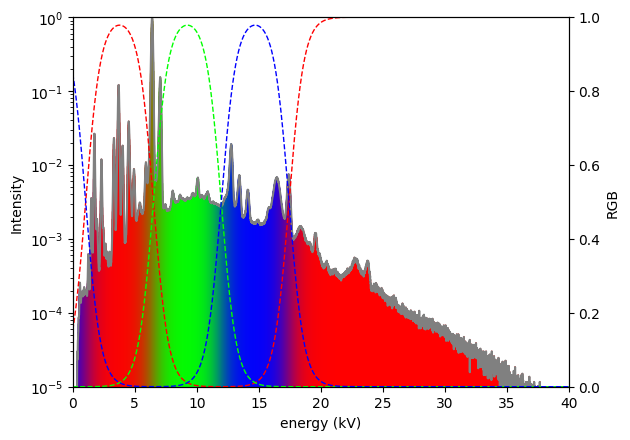

<Figure size 640x480 with 0 Axes>

In [150]:
# from:
# https://stackoverflow.com/questions/11564273/matplotlib-continuous-colormap-fill-between-two-lines

import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm

nview=2500
vymin=-1
vymin=0

venergy=energy
ps=classavg[1,1]
#ps=np.log(ps) #/max(clustaverages[1,1])
ps=ps/max(ps)

vred=colour.red
vgreen=colour.green
vblue=colour.blue

gsum=vred+vgreen+vblue



fig, ax1 = plt.subplots() 

ax1.set_xlabel('energy (kV)') 
ax1.set_ylabel('Intensity') 
ax1.axis(xmin=0,xmax=40)
ax1.set_yscale('log')
#ax1.axis(ymin=vymin,ymax=1)
ax1.axis(ymin=0.00001,ymax=1)

ax2 = ax1.twinx() 
ax2.set_ylabel('RGB')
ax2.axis(ymin=0,ymax=1)

ax2.plot(venergy, vred, '#ff0000', linestyle='dashed', linewidth=1)
ax2.plot(venergy, vgreen, '#00ff00', linestyle='dashed', linewidth=1)
ax2.plot(venergy, vblue, '#0000ff', linestyle='dashed', linewidth=1)

ax1.plot(venergy, ps, color="gray")
for i in range(len(ps) - 1):
    ax1.fill_between([energy[i], energy[i+1]], [ps[i], ps[i+1]], y2=vymin, color=(vred[i],vgreen[i],vblue[i]))

plt.show()

plt.savefig(os.path.join(config.odir, 'rgbgauss_spectrum.png'), dpi=150)


#plt.plot(ps)
#plt.bar(energy,plotspec,width=0.01)
#plt.show()





2052
(4096,)
colarray [1. 0. 0.]
(2044,)
(4096,)


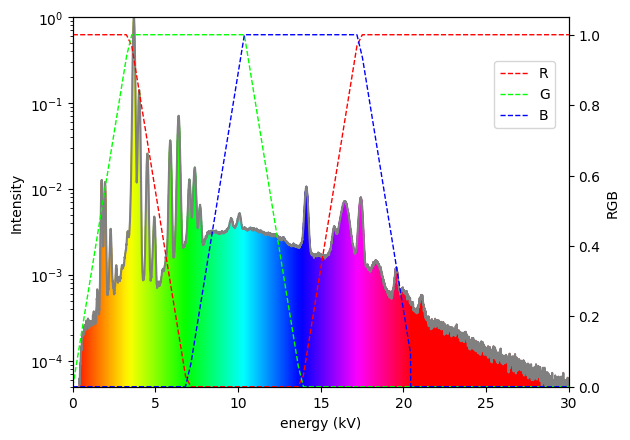

In [16]:
#import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

nview=2044
vymin=-1
vymin=0

venergy=energy
ps=classavg[1,1]
ps=ps/max(ps)

cred=np.zeros(config.NCHAN)
cgreen=np.zeros(config.NCHAN)
cred=np.zeros(config.NCHAN)

npad=config.NCHAN-nview

print(npad)

print(cred.shape)

hsv=cm.get_cmap('hsv', nview)

cmap=hsv(range(nview))
print('colarray',cmap[0,:3])    #index starts from 1 instead of 0, not sure why

cred=cmap[:,0]
cgreen=cmap[:,1]
cblue=cmap[:,2]

print(cred.shape)

cred=np.pad(cred, (0, npad), 'constant', constant_values=(0, 1))
cgreen=np.pad(cgreen, (0, npad), 'constant', constant_values=(0, 0))
cblue=np.pad(cblue, (0, npad), 'constant', constant_values=(0, 0))

print(cred.shape)


fig, ax1 = plt.subplots() 

ax1.set_xlabel('energy (kV)') 
ax1.set_ylabel('Intensity') 
ax1.axis(xmin=0,xmax=30)
ax1.set_yscale('log')
#ax1.axis(ymin=vymin,ymax=1)
ax1.axis(ymin=0.00005,ymax=1)

ax2 = ax1.twinx() 
ax2.set_ylabel('RGB')
ax2.axis(ymin=0,ymax=1.05)

ax2.plot(venergy, cred, '#ff0000', linestyle='dashed', linewidth=1, label="R")
ax2.plot(venergy, cgreen, '#00ff00', linestyle='dashed', linewidth=1, label="G")
ax2.plot(venergy, cblue, '#0000ff', linestyle='dashed', linewidth=1, label="B")

ax2.legend(loc=(0.85,0.7))

ax1.plot(venergy, ps, color="gray")
for i in range(len(ps) - 1):
    ax1.fill_between([energy[i], energy[i+1]], [ps[i], ps[i+1]], y2=vymin, color=(cred[i],cgreen[i],cblue[i]))


plt.savefig(os.path.join(odir, 'hsv_spectrum.png'), dpi=150)
plt.show()





11125
ADJUSTING BG


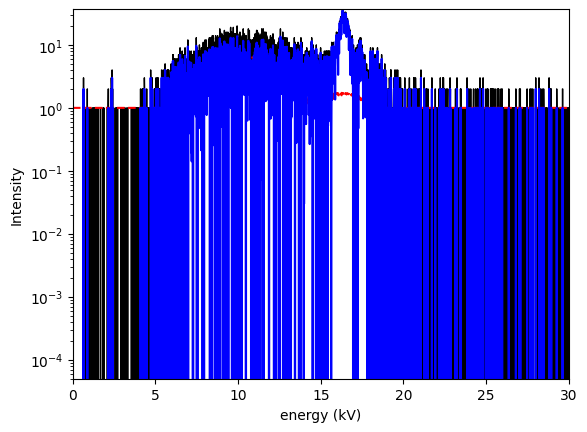

In [21]:
import src.fitting as fitting
import importlib
importlib.reload(fitting)

import matplotlib.pyplot as plt
import pybaselines.morphological

"""
SNIP TESTING
"""

nview=2044
vymin=-1
vymin=0

venergy=energy
#ps=clustaverages[1,1]
#ps=data[20000,:]
#ps=data[5000,:]
ps=data[3583,:]

print(np.sum(ps))

#ps=np.log(ps) #/max(clustaverages[1,1])
#ps=ps/max(ps)

ps2, bg=fitting.fitbaseline(ps,True)

fig, ax1 = plt.subplots() 

ax1.set_xlabel('energy (kV)') 
ax1.set_ylabel('Intensity') 
ax1.axis(xmin=0,xmax=30)
ax1.set_yscale('log')
ax1.axis(ymin=0.00005,ymax=max(ps))


ax1.plot(venergy, ps, color="black", linewidth=1)
ax1.plot(venergy, bg, color="red", linestyle='dashed')
ax1.plot(venergy, ps2, color="blue")

